In [0]:
%load_ext Cython

In [0]:
import nltk
nltk.download("reuters")
nltk.download("stopwords")

[nltk_data] Downloading package reuters to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
import nltk
from nltk.corpus import reuters
from nltk.stem import PorterStemmer
import numpy as np
ps = PorterStemmer()
stopwords = nltk.corpus.stopwords.words("english")
stopwords_stem = list(map(ps.stem, stopwords))

### Explore Dataset

In [0]:
len(reuters.fileids())

10788

In [0]:
corpus = [None]*len(reuters.fileids())

In [0]:
for i in range(len(corpus)):
    corpus[i] = " ".join(list(map(ps.stem, reuters.words(reuters.fileids()[i]))))

In [0]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
# pipe = Pipeline([('count', CountVectorizer(stop_words=stopwords_stem)),
#                  ('tfid', TfidfTransformer(use_idf=False))]).fit(corpus)
pipe = Pipeline([('count', CountVectorizer(stop_words=stopwords_stem))]).fit(corpus)

In [0]:
X = pipe.transform(corpus)

In [0]:
#pipe.named_steps['count'].vocabulary_

In [0]:
X.shape

(10788, 23218)

#### LDA Gibbs Explore

### Implement LDA

#### Convert X to np.array

In [0]:
X = X.toarray().astype(np.intc)

In [0]:
# for i in range(X.shape[0]):
#     X[i,:][X[i,:]>0] = 1
#     # for j in range(X.shape[1]):
#     #     if (X[i,j] > 0):
#     #         X[i,j] = 1

In [0]:
num_topics=5
alpha_=0.1
gamma_=0.01
random_state=1

In [0]:
word_topics = np.random.choice(np.arange(0, num_topics), size=X.shape).astype(np.intc)
    
# Nullify assignments for words that have zero count. We use a topic assignment, num_topics + 1, as a placeholder 
for i in range(word_topics.shape[0]):
    word_topics[i][(X[i].flatten() == 0)] = num_topics + 1

# Now we obtain local document topic counts
doc_topics = np.empty((X.shape[0], num_topics),dtype=np.intc)
for topic in range(num_topics):
    doc_topics[:,topic] = np.sum(np.array((word_topics == topic), dtype=np.intc) * X, axis=1)

# Now we obtain global document topic word counts
topic_words_global = np.empty((num_topics, X.shape[1]), dtype=np.intc)
for topic in range(num_topics):
    topic_words_global[topic, :] = np.sum(np.array((word_topics == topic), dtype=np.intc) * X, axis=0)    

# Calclate and Set Parameters
sum_Vm = topic_words_global.sum(axis=1)
V=X.shape[1]
num_iter = 25

In [0]:
doc_topics

array([[ 66,  93,  75, 115,  98],
       [ 17,  17,  14,   8,  14],
       [ 19,  25,  27,  32,  18],
       ...,
       [  3,   4,   6,   3,   4],
       [ 21,  16,   8,  14,   8],
       [  8,   6,   4,   2,  11]], dtype=int32)

In [0]:
topic_words_global

array([[  97, 2101,    2, ...,    1,    1,    0],
       [  62, 2084,    2, ...,    0,    0,    0],
       [  75, 1992,    1, ...,    0,    0,    0],
       [  70, 2025,    2, ...,    1,    0,    0],
       [  60, 2075,    4, ...,    1,    0,    1]], dtype=int32)

In [0]:
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 2, 0, ..., 0, 0, 0]], dtype=int32)

In [0]:
sum_Vm = sum_Vm.astype(np.intc)

In [0]:
%%cython
import numpy as np
cimport numpy as np
cimport cython

@cython.boundscheck(False)  # turn off array bounds check
@cython.wraparound(False)   # turn off negative indices ([-1,-1])
def train(int[:,::1] X, int[:,::1] word_topics, int[:,::1] doc_topics, int[:,::1] topic_words_global, int[::1] sum_Vmb,
          long long V, long long num_topics, double alpha_, double gamma_, long long random_state, long long num_iter):    
    
    cdef int N_i, word_count_iv, topic_ij, topic_iv, topic_ass, temp_count, num_docs
    cdef double const_, theta_normalizer, beta_normalizer, log_like_sum
    cdef int[::1] sum_Vm
    cdef double[:,::1] theta
    cdef double[:,::1] beta
    cdef double[:,::1] loglike
    
    num_docs = X.shape[0]
    
    for it in range(num_iter):
        for i in range(word_topics.shape[0]): # i is doc index: word_topics.shape[0] is num_docs
            N_i = np.sum(X[i]) # Number of words in document i

            for v in range(V): # v is word index: word_topics.shape[1] is V

                word_count_iv = X[i,v]
                if word_count_iv == 0:
                    continue

                # We want to re-assign word_topic_iv
                # First we decrement document-level statistics
                topic_iv = word_topics[i,v] # topic assigned to word iv
                #print(i,v,topic_iv)

                # Decrement document_topics
                doc_topics[i, topic_iv] -= word_count_iv
                doc_topic_i = doc_topics[i].copy()
                #print("doc_topic_i", np.array(doc_topic_i))
                #doc_topic_i[topic_iv] -= word_count_iv

                # Decrement global topic_words
                topic_words_global[topic_iv, v] -= word_count_iv
                topic_words_v = topic_words_global[:,v].copy()
                #print("topic_words_v", np.array(topic_words_v))
                #topic_words_v[topic_iv] -= word_count_iv

                # Because of sum_Vm we also need to update the global count
                #topic_words_global[:,v] = topic_words_v
                #topic_words_global[k,v]
                #for idx in range(topic_words_global.shape[0]):
                #    topic_words_global[idx,v] = topic_words_v[idx]

                # How much doc likes topic, dim K
                partA = np.zeros(num_topics)
                for k in range(num_topics):
                    partA[k] = (doc_topic_i[k] + alpha_)/(N_i - 1 + num_topics*alpha_) # dim K
                #partA = (doc_topic_i + alpha_)/(N_i - 1 + num_topics*alpha_) # dim K
                #print(partA)

                # How much each topic like word, dim K
                #partB = (topic_words_v + gamma_)/(sum_Vm + V*gamma_)

                # How much each topic like word
                #sum_Vm = np.sum(topic_words_global, axis=1)

                sum_Vm = np.zeros(num_topics, dtype=np.intc) 
                # sum_Vm[k] is number of times topic k has been assigned in the corpus. 
                for k in range(num_topics):
                    sum_Vm[k] = np.sum(topic_words_global[k,:])

                partB = np.zeros(num_topics)
                for k in range(num_topics):
                    partB[k] = (topic_words_v[k] + gamma_)/(sum_Vm[k] + V*gamma_)


                #prob_unnormalized
                prob_unorm = partA*partB
                const_ = np.sum(prob_unorm)
                prob = prob_unorm/const_

                # Draw a topic based on prob
                topic_ass = np.random.choice(np.arange(0, num_topics), p=prob)

                #Update Counts
                #doc_topic_i[topic_ass] += word_count_iv
                #topic_words_i[topic_ass] += word_count_iv

                doc_topics[i, topic_ass] += word_count_iv
                topic_words_global[topic_ass, v] += word_count_iv
                
                doc_topic_i = doc_topics[i].copy()
                #print("doc_topic_i", np.array(doc_topic_i))
                
                topic_words_v = topic_words_global[:,v].copy()
                #print("topic_words_v", np.array(topic_words_v))

                #doc_topics[i,:] = doc_topic_i
                #for idx in range(doc_topics.shape[1]):
                #    doc_topics[i,idx] = doc_topic_i[idx]


                #topic_words_global[:,v] = topic_words_v 
                #for idx in range(topic_words_global.shape[0]):
                #    topic_words_global[idx,v] = topic_words_v[idx]

                #Update assignment
                word_topics[i,v] = topic_ass
                #import pdb; pdb.set_trace()
#     return topic_words_global, doc_topics
            
        theta = np.zeros((word_topics.shape[0], num_topics), dtype=np.float_)
        beta = np.zeros((num_topics, V), dtype=np.float_)

        # Calculate theta (Sec 7)
        for i in range(theta.shape[0]):
            for k in range(theta.shape[1]):

                #np.sum(np.array((word_topics[i,:] == k), dtype=np.intc) * X, axis=1)
                temp_count = 0
                for v in range(V):
                    if (word_topics[i,v] == k):
                        temp_count += X[i,v]
                theta[i,k] = (temp_count + alpha_) # Note that this not normalized. we will do outside the loop

            # Now we normalize
            theta_normalizer = num_topics*alpha_ + np.sum(theta[i,:])       
            for k in range(theta.shape[1]):
                theta[i,k] = theta[i,k]/theta_normalizer

        # Calculate beta (Sec 8)
        for k in range(beta.shape[0]):
            for v in range(V):

                # np.sum(np.array((word_topics[:,v] == k), dtype=np.intc) * X, axis=0)
                temp_count = 0
                for i in range(num_docs):
                    if (word_topics[i,v] == k):
                        temp_count += X[i,v]
                beta[k,v] = (temp_count + gamma_)

            # Now we normalize
            beta_normalizer = V*gamma_ + np.sum(beta[:,v])
            for v in range(V):
                beta[k,v] = beta[k,v]/beta_normalizer

        log_like_sum = 0
        if ((it + 1) % 4 == 1 or it == 0 or it==(num_iter-1)):
            #if True:
            for i in range(X.shape[0]):
                for j in range(X.shape[1]):
                    topic_ij = word_topics[i,j]
                    #log_like[i,v] = np.log(beta[topic_iv])
                    log_like = X[i,j]*(np.log(beta[topic_ij,j]) + np.log(theta[i, topic_ij]))
                    log_like_sum += log_like

            print(log_like_sum)
    
    return beta, theta, topic_words_global, doc_topics

            #import pdb; pdb.set_trace()

#### Train

In [0]:
import time
time0 = time.time()
beta, theta, topic_words_global, doc_topics = train(X, word_topics, doc_topics, topic_words_global, sum_Vm, V, num_topics, alpha_, gamma_, random_state, num_iter)
print(time.time() -time0)

-1851575.2663594345
-1347160.6884145404
-907452.9994037489
-665135.9190033425
-542154.7068081292
-474198.0026794867
-434819.6054196948
8274.408559322357


In [0]:
np.array(doc_topics)

array([[  0,   0,  22,  78, 347],
       [  0,  39,   0,  18,  13],
       [  9,   1,  14,  48,  49],
       ...,
       [ 20,   0,   0,   0,   0],
       [ 65,   0,   0,   2,   0],
       [ 31,   0,   0,   0,   0]], dtype=int32)

In [0]:
#print(topic_words_global[:,77])

In [0]:
word_topics[0,155]

3

In [0]:
np.array(topic_words_global)

array([[  43, 7544,    9, ...,    3,    1,    0],
       [ 112, 2314,    0, ...,    0,    0,    0],
       [  80,  304,    1, ...,    0,    0,    0],
       [ 115,  115,    1, ...,    0,    0,    0],
       [  14,    0,    0, ...,    0,    0,    1]], dtype=int32)

In [0]:
# Calculate theta (Sec 7)
for i in range(theta.shape[0]):
    for k in range(theta.shape[1]):

        #np.sum(np.array((word_topics[i,:] == k), dtype=np.intc) * X, axis=1)
        temp_count = 0
        for v in range(V):
            if (word_topics[i,v] == k):
                temp_count += X[i,v]
        theta[i,k] = (temp_count + alpha_) # Note that this not normalized. we will do outside the loop

    # Now we normalize
    theta_normalizer = num_topics*alpha_ + np.sum(theta[i,:])       
    for k in range(theta.shape[1]):
        theta[i,k] = theta[i,k]/theta_normalizer

# Calculate beta (Sec 8)
for k in range(beta.shape[0]):
    for v in range(V):

        # np.sum(np.array((word_topics[:,v] == k), dtype=np.intc) * X, axis=0)
        temp_count = 0
        for i in range(num_docs):
            if (word_topics[i,v] == k):
                temp_count += X[i,v]
        beta[k,v] = (temp_count + gamma_)

    # Now we normalize
    beta_normalizer = V*gamma_ + np.sum(beta[:,v])
    for v in range(V):
        beta[k,v] = beta[k,v]/beta_normalizer

###  Translate back to vector form

In [0]:
#pipe.named_steps['count'].vocabulary_

In [0]:
inv_vocab = dict((v,k) for (k,v) in pipe.named_steps['count'].vocabulary_.items())

In [0]:
def print_top_words(beta, num_words):
    for i in range(beta.shape[0]):
        str_ = "Topic " + str(i) + ": "
        for word_idx in beta[i].argsort()[::-1][:num_words]:
            str_ = str_ + " " + inv_vocab[word_idx]
        print(str_)
        

In [0]:
print_top_words(np.array(beta), 20)

Topic 0:  vs mln ct 000 net dlr shr loss lt profit qtr rev year oper note inc sale 1986 31 share
Topic 1:  said tonn 000 mln year export price wheat product dlr 1986 grain sugar last 87 per pct corn crop agricultur
Topic 2:  said lt compani share dlr inc corp mln pct stock offer group co unit acquir sale oil acquisit ltd sharehold
Topic 3:  pct said billion year bank mln dlr rate 1986 februari rise januari rose quarter last 1987 expect increas reserv month
Topic 4:  said would trade market japan dollar offici price oil meet new govern countri could state say industri also told bank


In [0]:
for i in range(beta.shape[0]):
  print(np.sort(beta[i])[::-1][:20]/np.sum(beta[i]))

[0.07943213 0.06087173 0.04567738 0.04183443 0.03682695 0.02972331
 0.02916877 0.0290745  0.01852718 0.01547168 0.01486723 0.01336998
 0.01109082 0.01102982 0.00886712 0.00846231 0.00703715 0.0069096
 0.00645488 0.00644379]
[0.02542419 0.02296693 0.01876607 0.01810107 0.01111856 0.01028326
 0.00891271 0.00839368 0.00793143 0.00766381 0.00687716 0.00644734
 0.0064149  0.0060824  0.00595265 0.00557149 0.00543362 0.0053363
 0.00523088 0.00497137]
[0.04237644 0.02582501 0.02279461 0.02183375 0.02175983 0.01238775
 0.01083559 0.01052516 0.00994865 0.00977126 0.00881532 0.00758838
 0.00677534 0.00607564 0.00583912 0.00546956 0.00534145 0.00523797
 0.00488812 0.00486348]
[0.03778151 0.02428276 0.02315383 0.02068632 0.01836395 0.01765971
 0.01615985 0.01175166 0.0114076  0.00800469 0.00795631 0.00795631
 0.006822   0.00651558 0.0062898  0.00620916 0.0059995  0.00591349
 0.00567157 0.00562319]
[0.03358061 0.01306671 0.01169495 0.00894039 0.00605712 0.00575923
 0.00574084 0.00552018 0.00539514 0

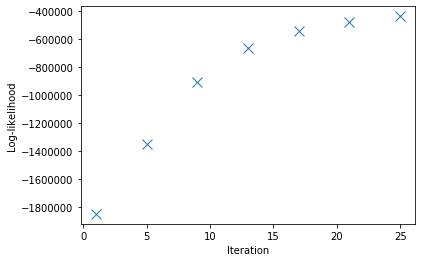

In [0]:
import matplotlib.pyplot as plt
plt.plot([1,5,9,13,17,21,25],[-1851575.2663594345, -1347160.6884145404, -907452.9994037489, -665135.9190033425, -542154.7068081292, 
                -474198.0026794867, -434819.6054196948], "x", MarkerSize=10)
#plt.yscale("symlog")
#plt.ylim((-1*10**12, -1*10**8))
plt.xlabel("Iteration")
plt.ylabel("Log-likelihood")
plt.savefig("LDA_gibbs.png")